In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor


In [22]:

data = pd.read_csv("walmart_sales.csv", parse_dates=["Date"])

data.head()



,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [23]:
print(data.info())

# Check missing values
print(data.isnull().sum())

# Sort by date
data = data.sort_values("Date")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [24]:
data["Date"] = pd.to_datetime(data["Date"], errors="coerce")

In [25]:
data = data.dropna(subset=["Date"])
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Week"] = data["Date"].dt.isocalendar().week.astype(int)
data["Day"] = data["Date"].dt.day

# Lag features (previous week’s sales)
data["Lag_1"] = data["Weekly_Sales"].shift(1)
data["Lag_2"] = data["Weekly_Sales"].shift(2)

# Rolling average features
data["Rolling_4"] = data["Weekly_Sales"].shift(1).rolling(window=4).mean()
data["Rolling_12"] = data["Weekly_Sales"].shift(1).rolling(window=12).mean()

# Drop NaN from lag/rolling
data = data.dropna()

print(data.head())

      Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
3063     22 2011-01-04     951588.37             0        36.04       3.638   
2491     18 2011-01-04     938083.17             0        35.06       3.638   
4922     35 2011-01-04     762620.94             0        37.27       3.638   
5923     42 2011-01-04     508432.17             0        67.64       3.772   
1347     10 2011-01-04    1827733.18             0        67.64       3.772   

             CPI  Unemployment  Year  Month  Week  Day       Lag_1  \
3063  137.955893         8.252  2011      1     1    4  1258674.12   
2491  134.068258         8.975  2011      1     1    4   951588.37   
4922  137.955893         8.512  2011      1     1    4   938083.17   
5923  128.719935         8.494  2011      1     1    4   762620.94   
1347  128.719935         8.494  2011      1     1    4   508432.17   

           Lag_2    Rolling_4     Rolling_12  
3063   459756.11  642150.3925  910887.070000  
2491  1258

In [26]:
# 4. Train/Test Split
# Use last few months as test set (time-aware split)
train_size = int(0.8 * len(data))
train, test = data.iloc[:train_size], data.iloc[train_size:]

X_train = train[["Year","Month","Week","Day","Lag_1","Lag_2","Rolling_4","Rolling_12"]]
y_train = train["Weekly_Sales"]

X_test = test[["Year","Month","Week","Day","Lag_1","Lag_2","Rolling_4","Rolling_12"]]
y_test = test["Weekly_Sales"]

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (2042, 8)  Test shape: (511, 8)


In [27]:
# 5. Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression Performance:")
print("R2:", r2_score(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))


Linear Regression Performance:
R2: -0.003325222460207833
RMSE: 561178.2495622773
MAE: 474119.7243816697


In [28]:
# 6. XGBoost Model
xgb = XGBRegressor(
    n_estimators=300, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost Performance:")
print("R2:", r2_score(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))


XGBoost Performance:
R2: -0.20625481320121297
RMSE: 615317.8227846579
MAE: 507677.65958170255


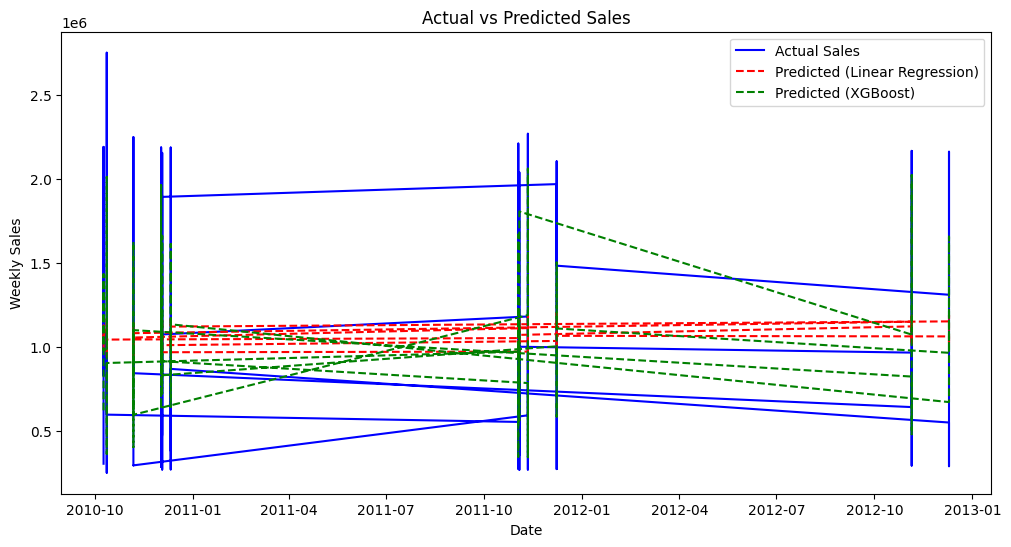

In [29]:
# 7. Plot actual vs predicted sales

plt.figure(figsize=(12,6))
plt.plot(test["Date"], y_test, label="Actual Sales", color="blue")
plt.plot(test["Date"], y_pred_lr, label="Predicted (Linear Regression)", color="red", linestyle="--")
plt.plot(test["Date"], y_pred_xgb, label="Predicted (XGBoost)", color="green", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.title("Actual vs Predicted Sales")
plt.legend()
plt.show()


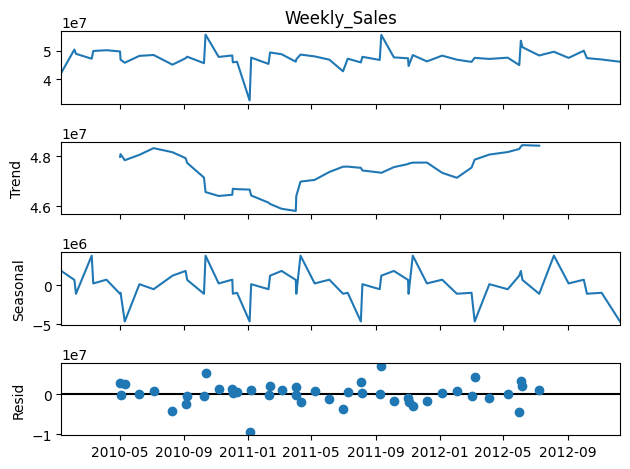

In [30]:
# 8. Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Use a single store's sales series for decomposition
store_sales = data.groupby("Date")["Weekly_Sales"].sum()

decomposition = seasonal_decompose(store_sales, model="additive", period=12)  # weekly seasonality
decomposition.plot()
plt.show()


In [31]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

In [32]:
from lightgbm import early_stopping, log_evaluation
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.metrics import mean_squared_error
# import numpy as np

features = ["Year","Month","Week","Day","Lag_1","Lag_2","Rolling_4","Rolling_12"]

# Time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=5)
lgb_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
    train = data.iloc[train_idx]
    val   = data.iloc[val_idx]
    
    X_train, y_train = train[features], train["Weekly_Sales"]
    X_val, y_val = val[features], val["Weekly_Sales"]
    
    # LightGBM regressor
    lgb_reg = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    
    # ✅ Use callbacks for early stopping + logging
    lgb_reg.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="rmse",
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]  # 0 = silent, change to 50 to log every 50 iters
    )
    
    y_val_pred = lgb_reg.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    lgb_scores.append(rmse)
    print(f"Fold {fold+1}: RMSE = {rmse:.2f}")

print("Average RMSE (LightGBM, TimeSeriesSplit):", np.mean(lgb_scores))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 594
[LightGBM] [Info] Number of data points in the train set: 428, number of used features: 8
[LightGBM] [Info] Start training from score 1048080.702285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [33]:
# Final split (like before)
train_size = int(0.8 * len(data))
train, test = data.iloc[:train_size], data.iloc[train_size:]

X_train, y_train = train[features], train["Weekly_Sales"]
X_test, y_test = test[features], test["Weekly_Sales"]

# Train final LightGBM
final_lgb = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
final_lgb.fit(X_train, y_train)

y_pred_lgb = final_lgb.predict(X_test)

print("LightGBM Final Performance:")
print("R2:", r2_score(y_test, y_pred_lgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lgb)))
print("MAE:", mean_absolute_error(y_test, y_pred_lgb))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1072
[LightGBM] [Info] Number of data points in the train set: 2042, number of used features: 8
[LightGBM] [Info] Start training from score 1062538.478254
LightGBM Final Performance:
R2: -0.20123275478609637
RMSE: 614035.5957278991
MAE: 506670.9387406875


Linear Regression: R2 = -0.003, RMSE = 561178.25
XGBoost: R2 = -0.206, RMSE = 615317.82
LightGBM: R2 = -0.201, RMSE = 614035.60


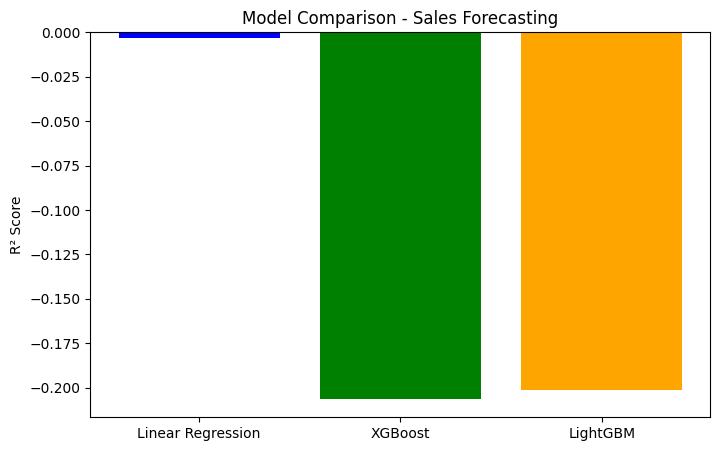

In [34]:
# Collect results
results = {
    "Linear Regression": {
        "R2": r2_score(y_test, y_pred_lr),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lr))
    },
    "XGBoost": {
        "R2": r2_score(y_test, y_pred_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    },
    "LightGBM": {
        "R2": r2_score(y_test, y_pred_lgb),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lgb))
    }
}

# Print results
for model, metrics in results.items():
    print(f"{model}: R2 = {metrics['R2']:.3f}, RMSE = {metrics['RMSE']:.2f}")

# Visualization
plt.figure(figsize=(8,5))
plt.bar(results.keys(), [m["R2"] for m in results.values()], color=["blue","green","orange"])
plt.ylabel("R² Score")
plt.title("Model Comparison - Sales Forecasting")
plt.show()
